In [119]:
import nltk
import tensorflow as tf
import pandas as pd
import numpy as np

# nltk.download('wordnet')

In [120]:
df = pd.read_csv(r'/content/drive/MyDrive/Eluvio_DS_Challenge.csv')
print(df.head())

   time_created date_created  up_votes  ...  over_18    author   category
0    1201232046   2008-01-25         3  ...    False     polar  worldnews
1    1201232075   2008-01-25         2  ...    False     polar  worldnews
2    1201232523   2008-01-25         3  ...    False     polar  worldnews
3    1201233290   2008-01-25         1  ...    False   fadi420  worldnews
4    1201274720   2008-01-25         4  ...    False  mhermans  worldnews

[5 rows x 8 columns]


In [191]:
df.describe()

,time_created,up_votes,down_votes
count,5.092360e+05,509236.000000,509236.0
mean,1.380240e+09,112.236283,0.0
std,7.090436e+07,541.694675,0.0
min,1.201232e+09,0.000000,0.0
25%,1.341585e+09,1.000000,0.0
50%,1.392909e+09,5.000000,0.0
75%,1.436527e+09,16.000000,0.0
max,1.479817e+09,21253.000000,0.0


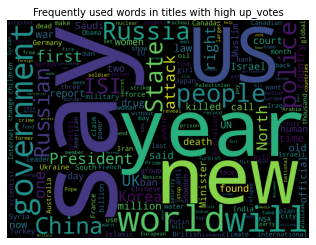

In [190]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt


text = df[df.up_votes>500].title.values

frequent_words = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500, height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Frequently used words in titles with high up_votes",fontsize=10)
plt.imshow(frequent_words)

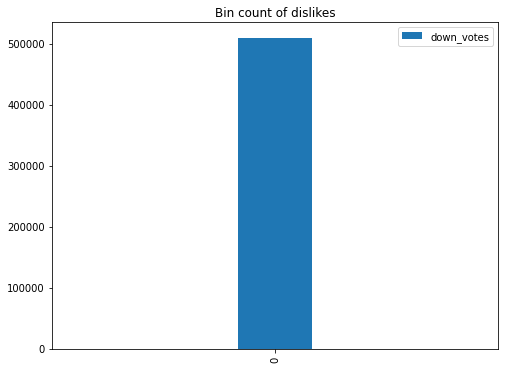

In [173]:
df.down_votes.value_counts().plot(kind='bar', figsize=(8,6), width=0.1, title='Bin count of dislikes', legend=True) # Static

In [81]:
df.down_votes.describe()

count    509236.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: down_votes, dtype: float64

Over the years the number of news articles published are increased. For 2016 we have data till november.

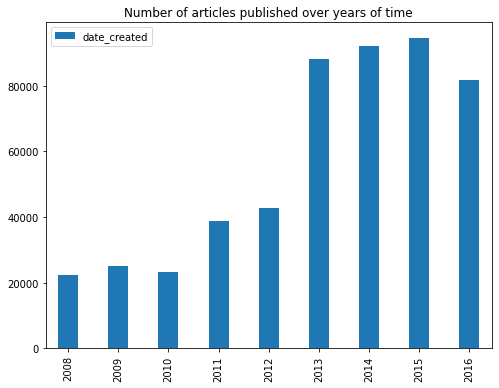

In [176]:
year = pd.DatetimeIndex(df.date_created).year
year.value_counts().loc[np.unique(year)].plot(kind='bar', figsize=(8,6), width=0.4, title='Number of articles published over years of time', legend = True) 

Looking for categories distribution.

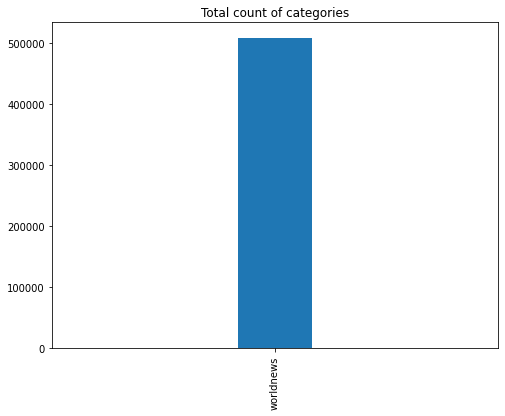

In [181]:
df.category.value_counts().plot(kind='bar', figsize=(8,6), width=0.1, title='Total count of categories')

Distribution of over 18 titles.

In [84]:
df.over_18.value_counts()

False    508916
True        320
Name: over_18, dtype: int64

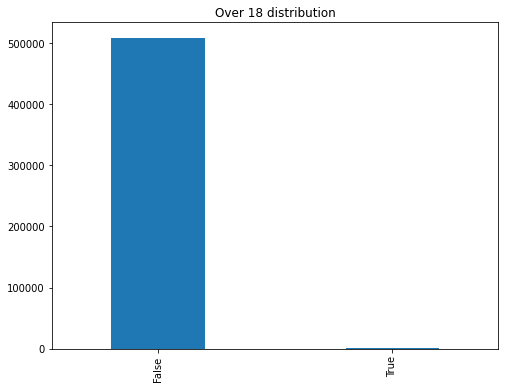

In [185]:
df.over_18.value_counts().plot(kind='bar',  figsize=(8,6), width=0.4, title='Over 18 distribution')

*Authors* with high up_votes for atleast 500 titles. 

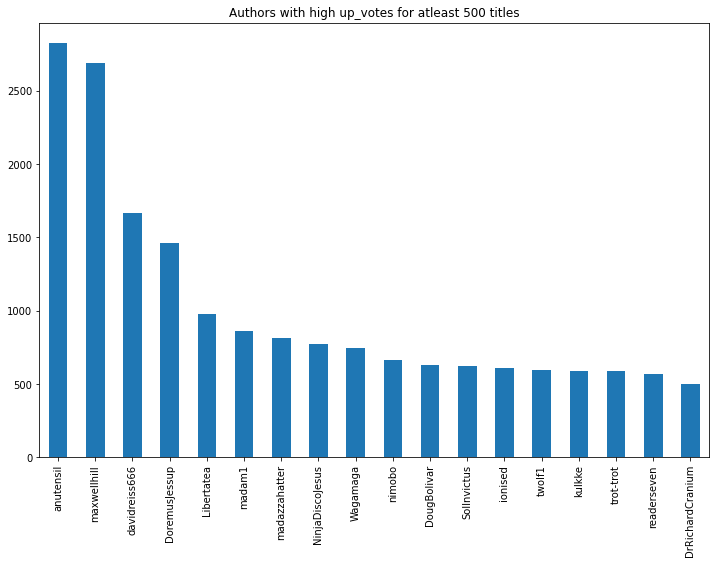

In [114]:
filtered_df = df[df.up_votes>16].author.value_counts()
filtered_df = filtered_df[filtered_df>500]
filtered_df.plot(kind='bar', figsize=(12,8), title='Authors with high up_votes for atleast 500 titles')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 <a list of 18 Text major ticklabel objects>)

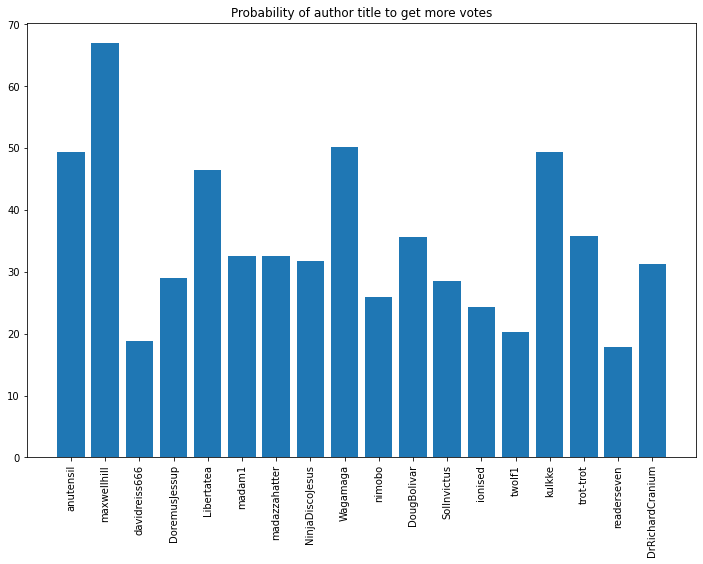

In [118]:
import matplotlib.pyplot as plt

hitPercentage = {}
for name in filtered_df.index:
    hitPercentage[name] = round((filtered_df[name]/len(df[df.author == name])) * 100,2)

plt.figure(figsize=(12, 8))
plt.bar(list(hitPercentage.keys()), list(hitPercentage.values()), align='center')
plt.title('Probability of author title to get more votes')
plt.xticks(rotation=90)

Binning up votes based on percentile for classification.

In [79]:
df['up_votes'].describe()

count    509236.000000
mean        112.236283
std         541.694675
min           0.000000
25%           1.000000
50%           5.000000
75%          16.000000
max       21253.000000
Name: up_votes, dtype: float64

In [88]:
bins = [5, 16, 21253]
labels=['no_votes', 'less_votes', 'few_votes', 'more_votes']
df['labels'] = pd.qcut(df.up_votes, q=4, labels=labels)
df.labels.value_counts()

no_votes      140174
less_votes    135680
more_votes    123886
few_votes     109496
Name: labels, dtype: int64

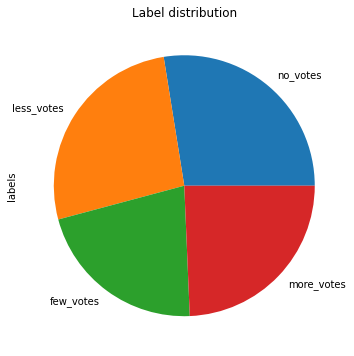

In [89]:
df.labels.value_counts().loc[labels].plot(kind='pie', figsize=(8,6), title='Label distribution')#, width=0.3)

In [91]:
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,labels
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews,less_votes
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews,less_votes
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews,less_votes
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews,no_votes
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews,less_votes


In [98]:
splitter = int(len(df)*0.8)
training_sentences = df.title[0:splitter]
testing_sentences = df.title[splitter:]
training_labels = df.labels[0:splitter]
testing_labels = df.labels[splitter:]

In [93]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [94]:
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('stopwords')

stops = set(stopwords.words("english"))
lemma = WordNetLemmatizer()
# all_words = []

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[\W]', ' ', text)
    text = re.sub(r'[^a-z0-1\s]', '', text) # Removes punctuation
    tags = pos_tag(text.split())
    filtered_words = []
    for index in range(len(tags)):
        if tags[index][0] not in stops and len(tags[index][0]) >= 3:
            filtered_words.append(lemma.lemmatize(tags[index][0], get_wordnet_pos(tags[index][0]))) 
    return ' '.join(filtered_words)


training_sentences = training_sentences.map(lambda x: clean_text(x))
testing_sentences = testing_sentences.map(lambda x: clean_text(x))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [95]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


tokenizer = Tokenizer(oov_token=oov_tok, num_words=20000)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
vocab_size = 20000 # len(tokenizer.word_index) + 1

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [99]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
training_labels = encoder.fit_transform(training_labels)
testing_labels = encoder.fit_transform(testing_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [100]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 32)                18560     
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 132       
Total params: 2,579,748
Trainable params: 2,579,748
Non-trainable params: 0
_________________________________________________________________


In [101]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

num_epochs = 15
filepath="weights-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
callbacks_list = [checkpoint, es]
history = model.fit(training_padded, training_labels, validation_split=0.2, epochs=num_epochs, batch_size=128, callbacks=callbacks_list , verbose=1) #validation_data=(testing_padded, testing_labels)

Epoch 1/15
2547/2547 [==============================] - 291s 113ms/step - loss: 1.3384 - accuracy: 0.3428 - val_loss: 1.3416 - val_accuracy: 0.3490

Epoch 00001: val_accuracy improved from -inf to 0.34900, saving model to weights-01-0.35.hdf5
Epoch 2/15
2547/2547 [==============================] - 281s 110ms/step - loss: 1.2770 - accuracy: 0.3988 - val_loss: 1.3577 - val_accuracy: 0.3398

Epoch 00002: val_accuracy did not improve from 0.34900
Epoch 3/15
2547/2547 [==============================] - 277s 109ms/step - loss: 1.2260 - accuracy: 0.4324 - val_loss: 1.3820 - val_accuracy: 0.3350

Epoch 00003: val_accuracy did not improve from 0.34900
Epoch 4/15
2547/2547 [==============================] - 272s 107ms/step - loss: 1.1638 - accuracy: 0.4714 - val_loss: 1.4382 - val_accuracy: 0.3237

Epoch 00004: val_accuracy did not improve from 0.34900
Epoch 00004: early stopping


In [133]:
model.evaluate(testing_padded, testing_labels)

3183/3183 [==============================] - 40s 13ms/step - loss: 1.4349 - accuracy: 0.3213


In [139]:
predictions = model.predict(testing_padded)

In [140]:
y_pred = []
for pred in predictions:
    y_pred.append(np.argmax(pred))

In [165]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(testing_labels, y_pred)

In [167]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

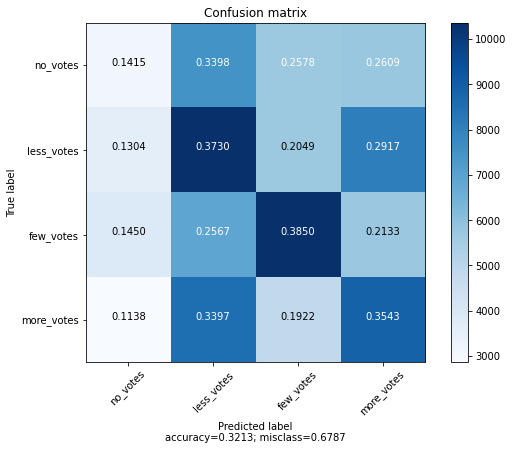

In [170]:
plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)